# makemore 3
Following a tutorial from [Andrej Karpathy](https://karpathy.ai/):
- [The spelled-out intro to language modeling: Building makemore Part 3: Activations & Gradients, BatchNorm](https://youtu.be/P6sfmUTpUmc?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

# Setup

In [ ]:
# !pip install torch matplotlib graphviz

# Load the data

In [4]:
words = open('names.txt', 'r').read().splitlines()

# Starting checkpoint
This is basically the state at which we left off last time. Make a model, train it on 3-grams or characters, and generate real-sounding names.

In [2]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# build the vocabulary and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

In [6]:
# build the dataset splits
block_size = 3 # the N-gram context size

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [14]:
# MLP model
n_embd = 10 # number of dimensions for the embedding
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [43]:
# hyper params
batch_size = 32
max_steps = 200000
learning_rate = 0.1
lossi = []

# train
for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    lr = learning_rate if i < 100000 else learning_rate / 10 # learning rate decay
    for p in parameters:
        p.data -= lr * p.grad

    # metrics
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


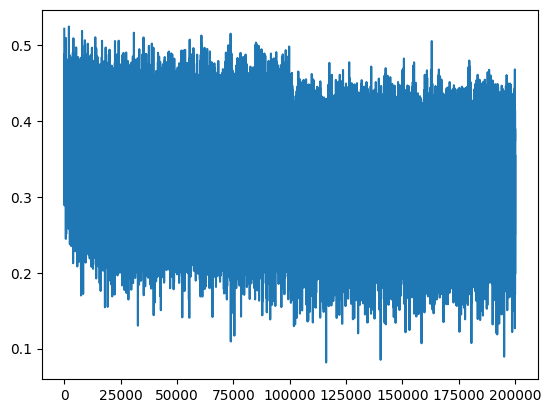

In [27]:
plt.plot(lossi)

In [28]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split:5} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.0696
val   loss: 2.1311


In [29]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    
    print(''.join(itos[i] for i in out))

junide.
jaycand.
presayleigh.
kai.
ronorian.
arett.
samela.
zamilena.
jadeyaire.
amellseen.
evy.
artez.
aveumahaf.
demmerppynsleigh.
ann.
core.
yaenacharesabille.
korin.
wyn.
neviansh.


# Improvements

## Starting loss
The vocabulary size is 27, so by default we expect the proba for each character to be $1 \over 27$

In [23]:
- torch.tensor(1.0/vocab_size).log()

tensor(3.2958)

But our starting loss was `27.8817` (instead of `3.2958`). So the starting weights are very confidently wrong.

To prevent that we want to squash the initialization values of the weight. Ideally we want every weights to be close to 0 but not exactly 0.0 to break symmetry.

In [41]:
# refactored model
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)              * 0.01
b2 = torch.randn(vocab_size, generator=g)                          * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

## tanh is too active
Too many elements get normalized to `-1` or `1` by the `torch.tanh()`. It means that our data have too extreme values. This is bad because the derivative of `tanh()` at `-1` or `1` is `0`. So the backpropagation gets nullified. Intuitively this happen because `tanh(500) ~= 1.0` and `tanh(50) ~= 1`. Why bother changing the value from `500` to `50` if it will output `1.0` regardless, and it wont influnce the loss.

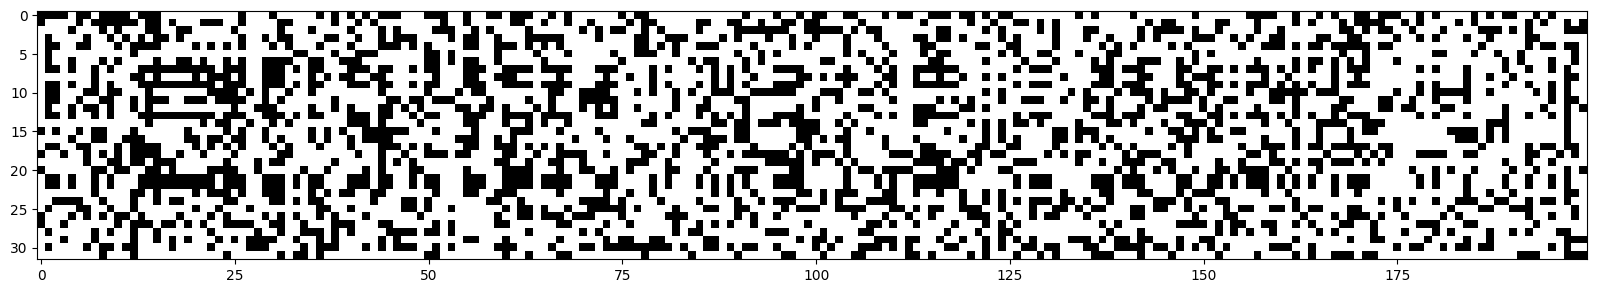

In [44]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

All the white pixels have value `> 0.99` so they destroy the backpropagation gradient.

NOTE: If we ever had an entire column being white. The corresponding neuron would be a `dead neuron` because there would be no way forward to train this neuron (because all gradients would be null).

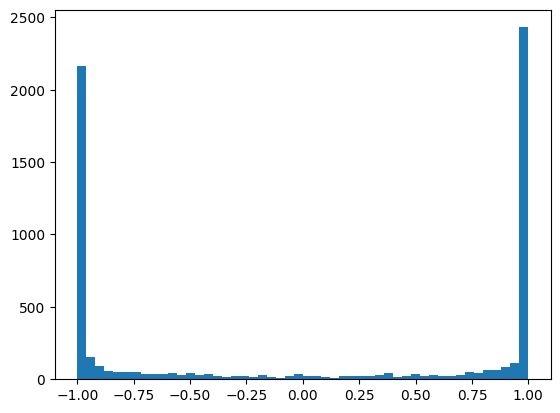

In [45]:
_ = plt.hist(h.view(-1).tolist(), 50)

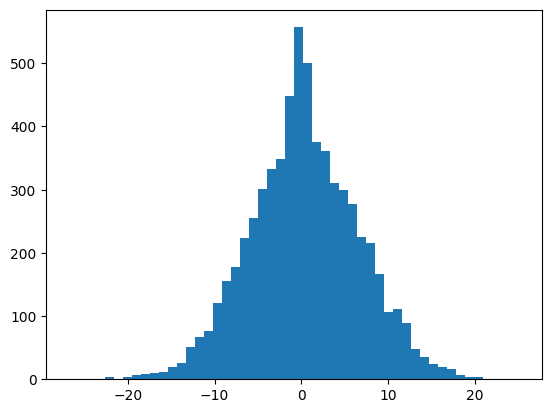

In [46]:
_ = plt.hist(hpreact.view(-1).tolist(), 50)

We can fix that by also scalling the initialization values of `W1` and `b1` by a factor of `0.1` (e.g. `W1 *= 0.1; b1 *= 0.01`).

### Automatic the initial value scaling

x.mean()=tensor(0.0076) x.std()=tensor(1.0009)
y.mean()=tensor(-0.0058) y.std()=tensor(3.1436)


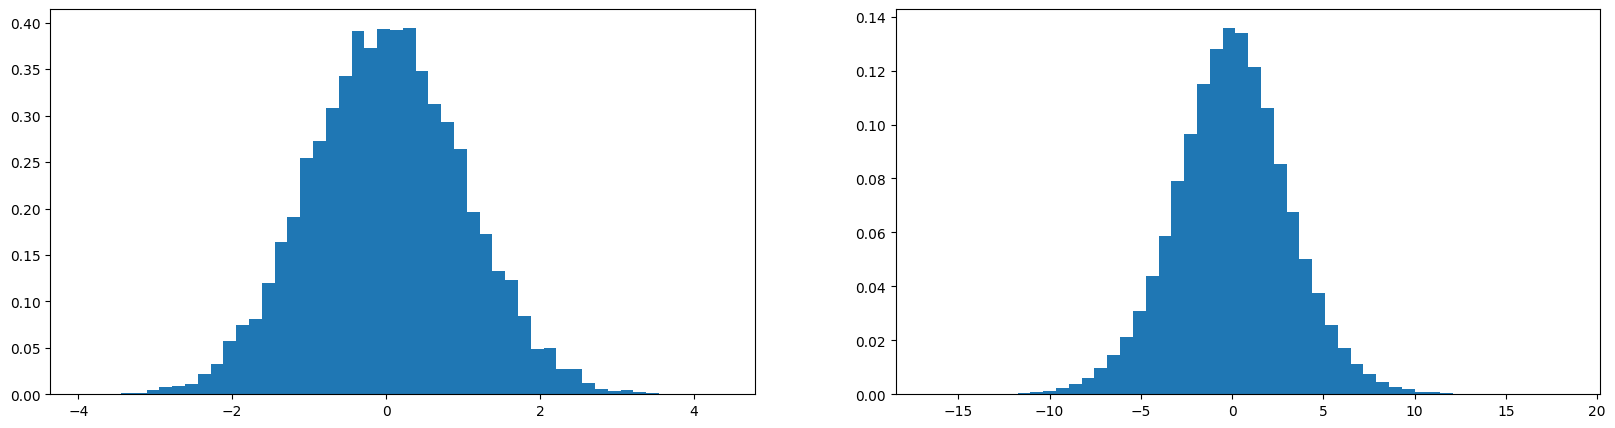

In [48]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(f'{x.mean()=} {x.std()=}')
print(f'{y.mean()=} {y.std()=}')
plt.figure(figsize=(20, 5))
plt.subplot(121)
_ = plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
_ = plt.hist(y.view(-1).tolist(), 50, density=True)

The matrix multiplication `x @ w` causes the standard deviation to increate. To prevent that the `w` matrix values should scaled by a factor of the square root of the `fan_in` (aka. input dimension) $\sqrt{fan\_in}$ (e.g. `w /= 10**0.5`).

x.mean()=tensor(-0.0199) x.std()=tensor(1.0033)
y.mean()=tensor(-0.0030) y.std()=tensor(0.9909)


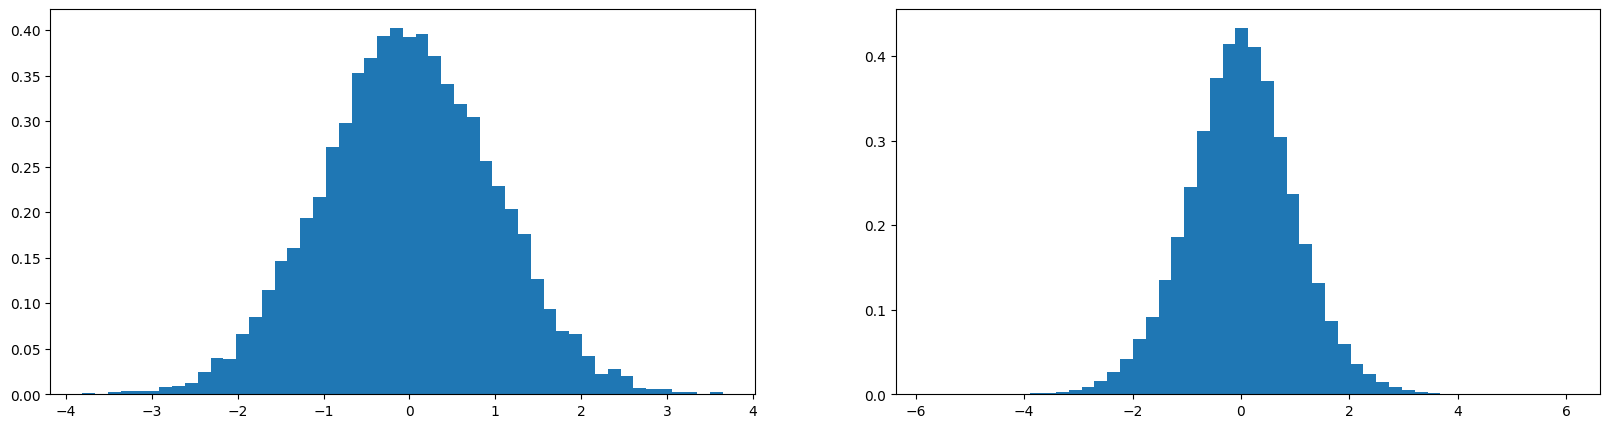

In [49]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(f'{x.mean()=} {x.std()=}')
print(f'{y.mean()=} {y.std()=}')
plt.figure(figsize=(20, 5))
plt.subplot(121)
_ = plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
_ = plt.hist(y.view(-1).tolist(), 50, density=True)

PyTorch has `torch.nn.init.kaiming_normal_` to automatically compute good initial weights based on the `fan_in`, and your non-linearity (aka. normalization function, i.e ReLU, Tanh).